# Dataset Column Names and Descriptions

## Column Names and Descriptions

1. **Global_active_power**: 
   - The total active power consumed by the household (in kilowatts).

2. **Global_reactive_power**: 
   - The total reactive power consumed by the household (in kilowatts).

3. **Voltage**: 
   - The average voltage (in volts) supplied to the household.

4. **Global_intensity**: 
   - The average current intensity (in amperes) drawn by the household.

5. **Sub_metering_1**: 
   - Energy sub-metering No. 1 (in watt-hours): corresponds to the kitchen (e.g., dishwasher, oven, microwave).

6. **Sub_metering_2**: 
   - Energy sub-metering No. 2 (in watt-hours): corresponds to the laundry room (e.g., washing machine, tumble dryer, refrigerator, light).

7. **Sub_metering_3**: 
   - Energy sub-metering No. 3 (in watt-hours): corresponds to the climate control systems (e.g., air conditioning, electric water heater).

8. **non_submetered**: 
   - Energy consumption not accounted for by the submeters (calculated as: Global_active_power * 1000 / 60 - sum of all submeters).

9. **DayCount**: 
   - The day of the year (1 to 365 or 366), starting from January 1st.

10. **DayOfWeek**: 
    - The day of the week (integer: Monday=0 to Sunday=6).

11. **IsWeekend**: 
    - Binary flag indicating if the day is a weekend (1 for Saturday and Sunday, 0 otherwise).

12. **Month**: 
    - The month of the year (integer: 1 for January to 12 for December).

13. **AvgTemperature**: 
    - The average daily temperature (in degrees Celsius).

14. **MinTemperature**: 
    - The minimum daily temperature (in degrees Celsius).

15. **MaxTemperature**: 
    - The maximum daily temperature (in degrees Celsius).

16. **Precipitation**: 
    - The total daily precipitation (in millimeters).

17. **tsun**: 
    - The total daily sunshine duration (in hours). Currently contains all zero values; may need verification.

## Notes:
- The dataset includes features derived from both energy consumption and weather data.
- Missing values in weather data have been handled using feature-specific imputation strategies.
- Temporal features (`DayCount`, `DayOfWeek`, `IsWeekend`, `Month`) were generated to assist in time-series analysis.


In [61]:
import os
import requests
import zipfile

# Define the URL and local filename
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
local_zip = 'household_power_consumption.zip'

# Download the dataset if it doesn't exist
if not os.path.exists(local_zip):
    response = requests.get(url)
    with open(local_zip, 'wb') as file:
        file.write(response.content)

# Extract the zip file
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall()


In [86]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = 'household_power_consumption.txt'
df = pd.read_csv(
    file_path,
    sep=';',
    parse_dates={'Datetime': ['Date', 'Time']},
    infer_datetime_format=True,
    na_values=['?'],
    low_memory=False
)

# Set 'Datetime' as the index
df.set_index('Datetime', inplace=True)

# Convert columns to numeric, handling non-numeric entries
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')


In [87]:
# Identify missing values per column
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

# Identify days with entirely missing data
missing_days = df.isnull().all(axis=1).resample('D').sum()
print("Days with entirely missing data:\n", missing_days[missing_days > 0])
# Convert the index to just the date (removes time part)
# Impute missing values using forward fill
df.fillna(method='ffill', inplace=True)

# Create the non_submetered column
df['non_submetered'] = df['Global_active_power'] * 1000 / 60 - (df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3'])

# Verify no missing values remain
print("Total missing values after imputation:", df.isnull().sum().sum())


Missing values per column:
 Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64
Days with entirely missing data:
 Datetime
2006-12-21       2
2006-12-30       2
2007-01-14       1
2007-01-28       1
2007-02-22       2
              ... 
2010-09-25    1204
2010-09-26    1440
2010-09-27    1440
2010-09-28    1153
2010-10-24       1
Length: 82, dtype: int64
Total missing values after imputation: 0


In [88]:
# Daily resampling of the data
df = df.resample('D').sum()
# Confirm data types are appropriate
print("Data types:\n", df.dtypes)

# Check for any remaining missing or malformed data
print("Summary statistics:\n", df.describe())


Data types:
 Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
non_submetered           float64
dtype: object
Summary statistics:
        Global_active_power  Global_reactive_power        Voltage  \
count          1442.000000            1442.000000    1442.000000   
mean           1563.162724             177.487871  346607.985166   
std             603.833832              50.688460    7377.591083   
min             210.240000               0.000000   93552.530000   
25%            1166.661500             141.884000  345698.442500   
50%            1542.486000             171.192000  346998.895000   
75%            1893.959000             203.678000  348313.510000   
max            4773.386000             417.834000  356306.410000   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \


In [89]:

# Calculate 'DayCount' as the day of the year
df['DayCount'] = df.index.dayofyear
# Extract additional temporal features
df['DayOfWeek'] = df.index.dayofweek
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
df['Month'] = df.index.month


In [90]:
df.head

<bound method NDFrame.head of             Global_active_power  Global_reactive_power    Voltage  \
Datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   
...                         ...                    ...        ...   
2010-11-22             2041.536                142.354  345883.85   
2010-11-23             1577.536                137.450  346428.76   
2010-11-24             1796.248                132.460  345644.59   
2010-11-25             1431.164                116.128  347812.21   
2010-11-26             1488.104                120.826  303487.57   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_meteri

In [91]:
# Install Meteostat library (if not already installed)
# !pip install meteostat

from meteostat import Point, Daily

# Define the location for Paris
paris = Point(48.8566, 2.3522)

# Define the date range based on the energy consumption data
start = df.index.min()  # Start date of energy data
end = df.index.max()    # End date of energy data

# Fetch daily weather data for Paris
weather_data = Daily(paris, start, end)
weather_data = weather_data.fetch()

# Reset index to align dates
weather_data.reset_index(inplace=True)

# Rename columns for clarity
weather_data.rename(columns={
    'time': 'Date',
    'tavg': 'AvgTemperature',
    'tmin': 'MinTemperature',
    'tmax': 'MaxTemperature',
    'prcp': 'Precipitation',
}, inplace=True)

# Set 'Date' as the index
weather_data.set_index('Date', inplace=True)

# Verify the fetched weather data
print("Weather data sample:\n", weather_data.head())


Weather data sample:
             AvgTemperature  MinTemperature  MaxTemperature  Precipitation  \
Date                                                                        
2006-12-16             6.2             3.8             8.6            0.0   
2006-12-17             4.4             1.1             7.9            3.3   
2006-12-18             4.6             3.4             6.0            0.0   
2006-12-19             2.6             0.5             5.2            0.0   
2006-12-20             2.9             0.5             5.7            0.0   

            snow   wdir  wspd  wpgt    pres  tsun  
Date                                               
2006-12-16   NaN  233.0  12.3   NaN  1024.1   NaN  
2006-12-17   NaN  217.0   4.6   NaN  1029.5   NaN  
2006-12-18   NaN  125.0   6.5   NaN  1029.0   NaN  
2006-12-19   NaN   22.0  14.8   NaN  1034.1   NaN  
2006-12-20   NaN   21.0  13.5   NaN  1037.5   NaN  


In [92]:
# Keep only the required columns
weather_data = weather_data[['AvgTemperature', 'MinTemperature', 'MaxTemperature', 'Precipitation', 'tsun']]

# Handle missing weather data
def handle_missing_weather_data(weather_df):
    # Impute precipitation: Assume 0 for missing values
    weather_df['Precipitation'] = weather_df['Precipitation'].fillna(0)

    # Impute temperature columns using interpolation
    weather_df['AvgTemperature'] = weather_df['AvgTemperature'].interpolate(method='linear')
    weather_df['MinTemperature'] = weather_df['MinTemperature'].interpolate(method='linear')
    weather_df['MaxTemperature'] = weather_df['MaxTemperature'].interpolate(method='linear')

    # Impute 'tsun' (sunshine duration) with linear interpolation or set to 0 for significant gaps
    weather_df['tsun'] = weather_df['tsun'].interpolate(method='linear').fillna(0)

    # Handle any remaining gaps with historical averages (if any)
    for col in ['AvgTemperature', 'MinTemperature', 'MaxTemperature']:
        weather_df[col] = weather_df[col].fillna(weather_df[col].mean())

    return weather_df

# Apply the function to the weather data
weather_data = handle_missing_weather_data(weather_data)

# Verify the resulting data
print("Filtered weather data with missing values handled:\n", weather_data.head())
print("Remaining missing values:\n", weather_data.isnull().sum())


Filtered weather data with missing values handled:
             AvgTemperature  MinTemperature  MaxTemperature  Precipitation  \
Date                                                                        
2006-12-16             6.2             3.8             8.6            0.0   
2006-12-17             4.4             1.1             7.9            3.3   
2006-12-18             4.6             3.4             6.0            0.0   
2006-12-19             2.6             0.5             5.2            0.0   
2006-12-20             2.9             0.5             5.7            0.0   

            tsun  
Date              
2006-12-16   0.0  
2006-12-17   0.0  
2006-12-18   0.0  
2006-12-19   0.0  
2006-12-20   0.0  
Remaining missing values:
 AvgTemperature    0
MinTemperature    0
MaxTemperature    0
Precipitation     0
tsun              0
dtype: int64


In [93]:
# Merge the energy consumption and weather data
# Ensure the energy data index is a DatetimeIndex for proper merging
df.index = pd.to_datetime(df.index)

# Resample weather data to daily frequency if necessary (e.g., mean values for missing dates)
weather_data = weather_data.resample('D').mean()

# Merge weather data with energy consumption data
df = df.merge(weather_data, left_index=True, right_index=True, how='left')

# Handle any missing values in weather data
df.fillna(method='ffill', inplace=True)  # Forward fill


In [94]:
# Verify the final dataset
print("Final dataset with weather data sample:\n", df.head())

# Check for missing values in weather columns
print("Missing values in weather columns:\n", df[['AvgTemperature', 'MinTemperature', 'MaxTemperature', 'Precipitation', ]].isnull().sum())


Final dataset with weather data sample:
             Global_active_power  Global_reactive_power    Voltage  \
Datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
Datetime                                                                       
2006-12-16            5180.8             0.0           546.0          4926.0   
2006-12-17           14398.6          2033.0          4187.0         13341.0   
2006-12-18            9247.2          1063.0          2621.0         14018.0   
2006-12-19            7094.0           839.0          7602.0          6197.

In [95]:
df.head

<bound method NDFrame.head of             Global_active_power  Global_reactive_power    Voltage  \
Datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   
...                         ...                    ...        ...   
2010-11-22             2041.536                142.354  345883.85   
2010-11-23             1577.536                137.450  346428.76   
2010-11-24             1796.248                132.460  345644.59   
2010-11-25             1431.164                116.128  347812.21   
2010-11-26             1488.104                120.826  303487.57   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_meteri

In [72]:
# Save the final dataset with weather data to a CSV file
df.to_csv('preprocessed_energy_with_weather_data.csv')


## New Ways of Outlier Detection using Prophet

18:51:23 - cmdstanpy - INFO - Chain [1] start processing
18:51:23 - cmdstanpy - INFO - Chain [1] done processing


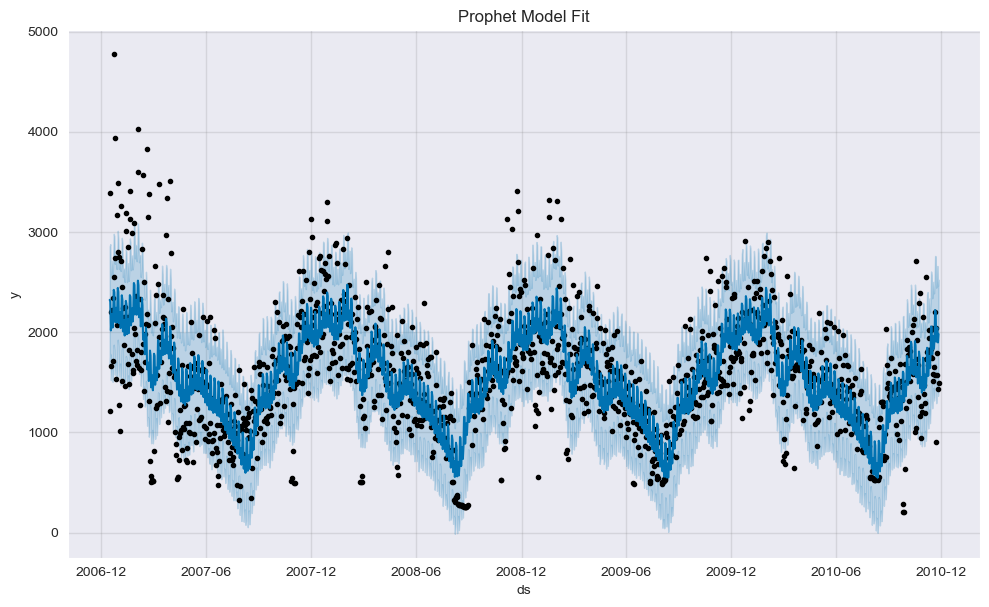

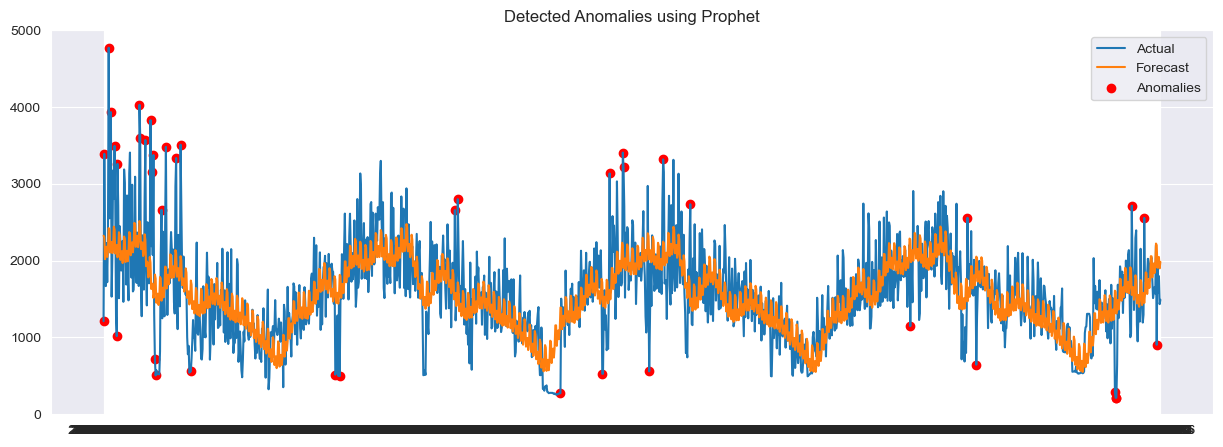

In [81]:
# Import libraries
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

daily_data = pd.read_csv("preprocessed_energy_with_weather_data.csv")
# Rename Datetime to Date
daily_data.rename(columns={"Datetime":"Date"}, inplace=True)
# Prepare data for Prophet
df_prophet = daily_data.reset_index()[['Date', 'Global_active_power']]
df_prophet.columns = ['ds', 'y']

# Initialize and fit the model
model = Prophet()
model.fit(df_prophet)

# Make predictions
future = model.make_future_dataframe(periods=0)  # No future periods needed
forecast = model.predict(future)

# Calculate residuals
df_prophet['yhat'] = forecast['yhat']
df_prophet['residuals'] = df_prophet['y'] - df_prophet['yhat']

# Identify anomalies
threshold = 2.5 * np.std(df_prophet['residuals'])
df_prophet['anomaly'] = df_prophet['residuals'].abs() > threshold

# Plot results
fig1 = model.plot(forecast)
plt.title('Prophet Model Fit')

# Plot anomalies
anomalies = df_prophet[df_prophet['anomaly']]
plt.figure(figsize=(15, 5))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual')
plt.plot(df_prophet['ds'], df_prophet['yhat'], label='Forecast')
plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomalies')
plt.legend()
plt.title('Detected Anomalies using Prophet')
plt.show()


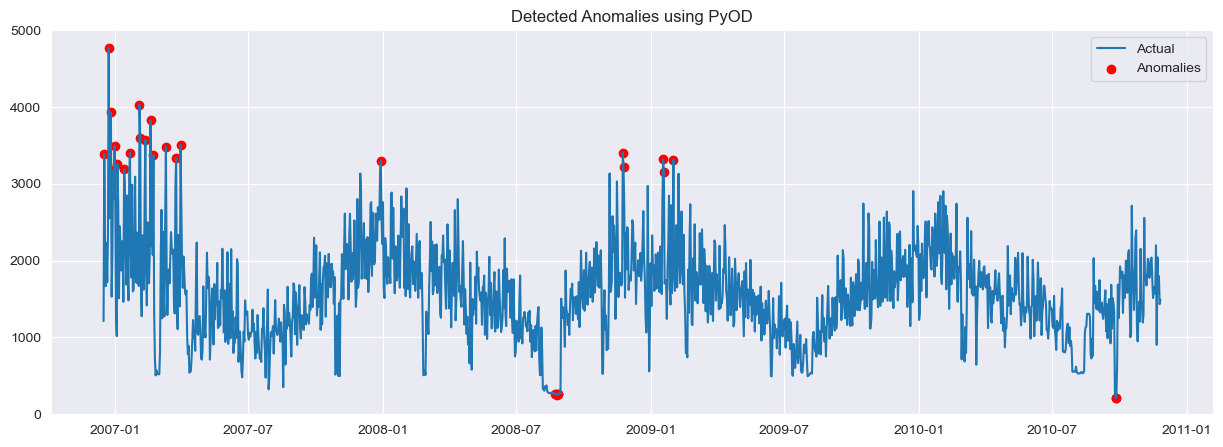

In [74]:
from pyod.models.iforest import IForest  # Isolation Forest from PyOD
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data
df_shesd = daily_data.reset_index()[['Date', 'Global_active_power']]
df_shesd.columns = ['timestamp', 'value']
df_shesd['timestamp'] = pd.to_datetime(df_shesd['timestamp'])

# Prepare data for anomaly detection
X = df_shesd[['value']].values

# Fit the Isolation Forest model
model = IForest(contamination=0.02, random_state=42)
model.fit(X)

# Predict anomalies
df_shesd['anomaly'] = model.labels_  # 1 for anomaly, 0 for normal

# Extract anomalies
anomalies = df_shesd[df_shesd['anomaly'] == 1]

# Plot results
plt.figure(figsize=(15, 5))
plt.plot(df_shesd['timestamp'], df_shesd['value'], label='Actual')
plt.scatter(anomalies['timestamp'], anomalies['value'], color='red', label='Anomalies')
plt.legend()
plt.title('Detected Anomalies using PyOD')
plt.show()


# Impute Values for Anomalies
Only for Prophet

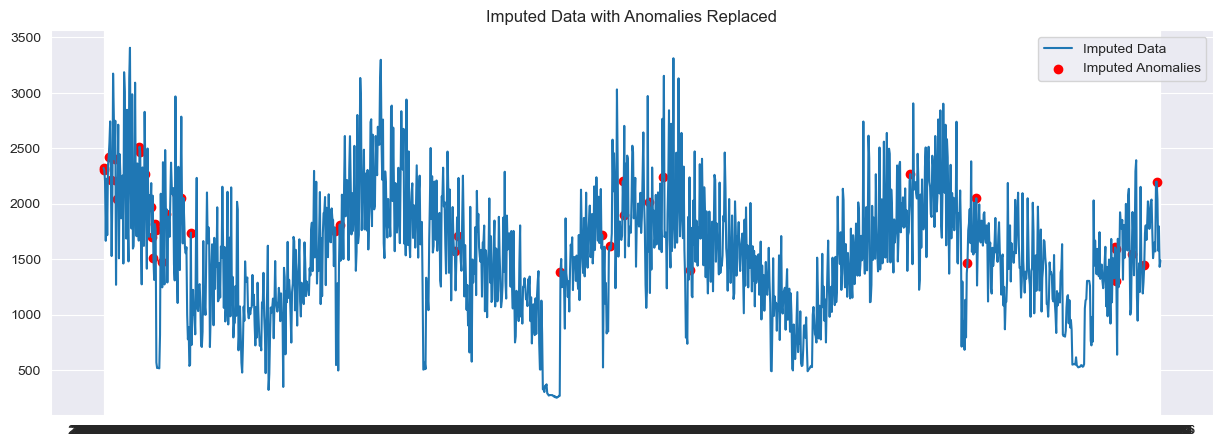

In [75]:
# Separate anomalies and non-anomalous data
non_anomalous_data = df_prophet[df_prophet['anomaly'] == False]
anomalous_data = df_prophet[df_prophet['anomaly'] == True]

# Replace anomalies with forecasted values
df_prophet.loc[df_prophet['anomaly'], 'y'] = df_prophet.loc[df_prophet['anomaly'], 'yhat']

plt.figure(figsize=(15, 5))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Imputed Data')
plt.scatter(anomalous_data['ds'], anomalous_data['yhat'], color='red', label='Imputed Anomalies')
plt.legend()
plt.title('Imputed Data with Anomalies Replaced')
plt.show()


In [83]:
# Assuming `daily_data` is the original DataFrame and `df_prophet` contains imputed values
# Align dates in both DataFrames
df_prophet.set_index('ds', inplace=True)  # Prophet DataFrame indexed by date
daily_data.set_index('Date', inplace=True)  # Original DataFrame indexed by date

# Update the original DataFrame with imputed values
daily_data['Global_active_power'] = df_prophet['y']

# Reset index for saving
daily_data.reset_index(inplace=True)




In [85]:
# Save the updated DataFrame to CSV
daily_data.to_csv('data_without_anomalies_prophet.csv', index=False)

print("Cleaned data saved to 'data_without_anomalies_prophet.csv'.")

Cleaned data saved to 'data_without_anomalies_prophet.csv'.


Index(['Date', 'Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'non_submetered', 'DayCount', 'DayOfWeek',
       'IsWeekend', 'Month', 'AvgTemperature', 'MinTemperature',
       'MaxTemperature', 'Precipitation', 'tsun'],
      dtype='object')